# This notebook plots distribution of grid point level rain rates and rain amounts by different types of convection for land & ocean

## The rainrate histogram data is produced by:
* /Analysis/calc_mcs_rainrate_hist_byregion.py

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import glob, os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import shapely.geometry as sgeom
from scipy import fftpack
%matplotlib inline

In [2]:
# Dictionary for official model names
model_name = {
    'obs': 'OBS',
    'CONTROLRUN': 'CTL',
    'HVMIXINGRUN10': 'HV10',
    'HVMIXINGRUN15': 'HV15',
}

# Specify region
region = 'fulldomain'

rootdir = '/pscratch/sd/f/feng045/iclass/amazon_hvmixing/'
obsdir = f'{rootdir}gpm/stats/'
obsfile = f'{obsdir}mcs_rainrate_hist_20140402_20140430_{region}.nc'

name_map = {
    'obs': 'obs',
    'm1': 'CONTROLRUN',
    'm2': 'HVMIXINGRUN10',
    'm3': 'HVMIXINGRUN15',
}
m1dir = f'{rootdir}{name_map["m1"]}/TRACK_DIR_REGRID/stats/'
m2dir = f'{rootdir}{name_map["m2"]}/TRACK_DIR_REGRID/stats/'
m3dir = f'{rootdir}{name_map["m3"]}/TRACK_DIR_REGRID/stats/'
m1file = f'{m1dir}mcs_rainrate_hist_20140402_20140430_{region}.nc'
m2file = f'{m2dir}mcs_rainrate_hist_20140402_20140430_{region}.nc'
m3file = f'{m3dir}mcs_rainrate_hist_20140402_20140430_{region}.nc'

figdir = f'/global/cfs/cdirs/m1657/zfeng/amazon_hvmixing/figures/'
os.makedirs(figdir, exist_ok=True)
print(figdir)

/global/cfs/cdirs/m1657/zfeng/amazon_hvmixing/figures/


In [3]:
obsfile, m1file, m2file, m3file

('/pscratch/sd/f/feng045/iclass/amazon_hvmixing/gpm/stats/mcs_rainrate_hist_20140402_20140430_fulldomain.nc',
 '/pscratch/sd/f/feng045/iclass/amazon_hvmixing/CONTROLRUN/TRACK_DIR_REGRID/stats/mcs_rainrate_hist_20140402_20140430_fulldomain.nc',
 '/pscratch/sd/f/feng045/iclass/amazon_hvmixing/HVMIXINGRUN10/TRACK_DIR_REGRID/stats/mcs_rainrate_hist_20140402_20140430_fulldomain.nc',
 '/pscratch/sd/f/feng045/iclass/amazon_hvmixing/HVMIXINGRUN15/TRACK_DIR_REGRID/stats/mcs_rainrate_hist_20140402_20140430_fulldomain.nc')

In [4]:
name_map.keys()

dict_keys(['obs', 'm1', 'm2', 'm3'])

In [5]:
datafiles = [obsfile, m1file, m2file, m3file]
# Read all data in Xarray Dataset
ds = xr.open_mfdataset(datafiles, concat_dim='source', combine='nested')
# Assign new coordinate 'source' using names
ds['source'] = ['obs', 'm1', 'm2', 'm3']
rrbins = ds.bins
lon_bounds = ds.attrs['lon_bounds']
lat_bounds = ds.attrs['lat_bounds']
ds

<xarray.Dataset>
Dimensions:          (source: 4, bins: 199)
Coordinates:
  * bins             (bins) int64 1 2 3 4 5 6 7 ... 193 194 195 196 197 198 199
  * source           (source) <U3 'obs' 'm1' 'm2' 'm3'
Data variables:
    total_land       (source, bins) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    mcs_land         (source, bins) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    idc_land         (source, bins) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    congestus_land   (source, bins) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    total_ocean      (source, bins) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    mcs_ocean        (source, bins) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    idc_ocean        (source, bins) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    congestus_ocean  (source, bins) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
Attributes:
    title:            Precipitation PDF by types
    lon_bounds:       [-79. -36.]
    lat_bounds:       [-18.  11.]
    landfrac_range:   [ 0. 10.]
    oceanfrac_range:  [ 99. 100.]
    contact:          Zhe Feng, zhe.feng@pnnl.gov
    created_on:       Thu Jun 22 14:36:13 2023

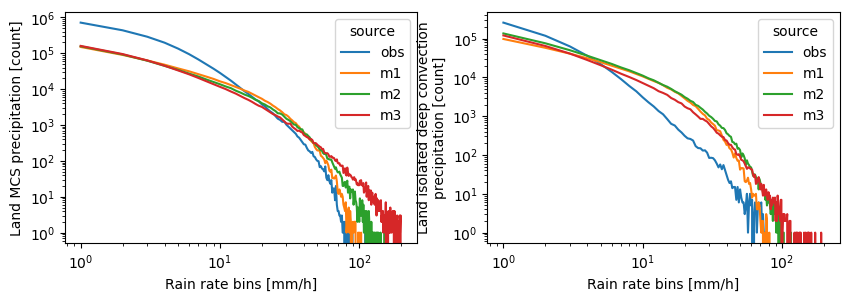

In [6]:
fig, axes = plt.subplots(1, 2, figsize=[10,3], dpi=100)
ax0 = axes[0]
xr.plot.line(ds.mcs_land, x='bins', ax=ax0)
ax0.set_yscale('log')
ax0.set_xscale('log')
ax1 = axes[1]
xr.plot.line(ds.idc_land, x='bins', ax=ax1)
ax1.set_yscale('log')
ax1.set_xscale('log')

## Normalize histogram by dividing the sum over all bins

In [7]:
norm_tot_o = ds.total_ocean / ds.total_ocean.sum(dim='bins')
norm_mcs_o = ds.mcs_ocean / ds.mcs_ocean.sum(dim='bins')
norm_idc_o = ds.idc_ocean / ds.idc_ocean.sum(dim='bins')
norm_cong_o = ds.congestus_ocean / ds.congestus_ocean.sum(dim='bins')

norm_tot_l = ds.total_land / ds.total_land.sum(dim='bins')
norm_mcs_l = ds.mcs_land / ds.mcs_land.sum(dim='bins')
norm_idc_l = ds.idc_land / ds.idc_land.sum(dim='bins')
norm_cong_l = ds.congestus_land / ds.congestus_land.sum(dim='bins')

## Calculate histogram of rain amount by rain rate

In [8]:
totamt_hist_o = ds.total_ocean * rrbins
mcsamt_hist_o = ds.mcs_ocean * rrbins
idcamt_hist_o = ds.idc_ocean * rrbins
congamt_hist_o = ds.congestus_ocean * rrbins

totamt_hist_l = ds.total_land * rrbins
mcsamt_hist_l = ds.mcs_land * rrbins
idcamt_hist_l = ds.idc_land * rrbins
congamt_hist_l = ds.congestus_land * rrbins

In [9]:
totamt_cumhist_o = totamt_hist_o.cumsum(dim='bins')
totamt_cumhist_l = totamt_hist_l.cumsum(dim='bins')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


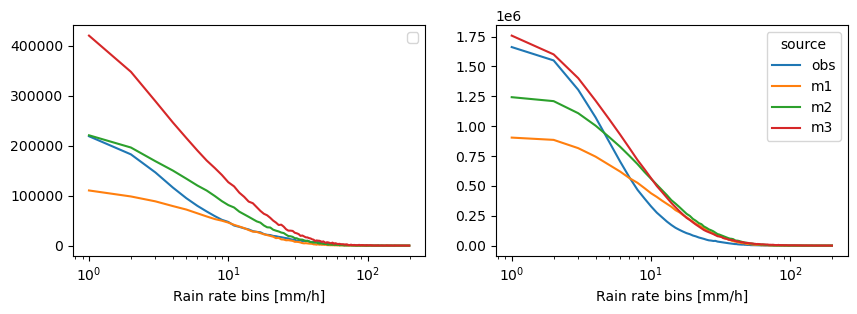

In [10]:
fig, axes = plt.subplots(1, 2, figsize=[10,3], dpi=100)
ax0 = axes[0]
xr.plot.line(totamt_hist_o, x='bins', ax=ax0)
# ax0.set_yscale('log')
ax0.set_xscale('log')
ax0.legend(loc='upper right')
ax1 = axes[1]
xr.plot.line(totamt_hist_l, x='bins', ax=ax1)
# ax1.set_yscale('log')
ax1.set_xscale('log')

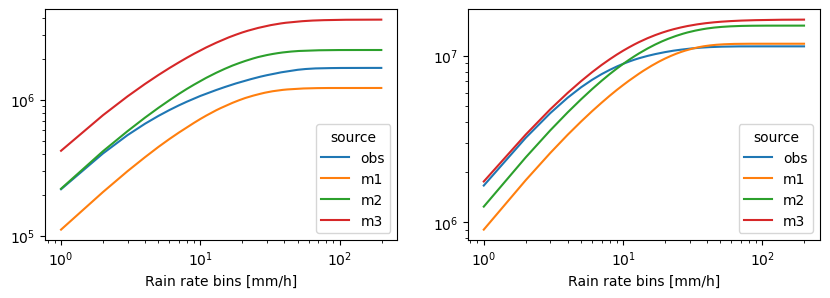

In [11]:
fig, axes = plt.subplots(1, 2, figsize=[10,3], dpi=100)
ax0 = axes[0]
xr.plot.line(totamt_cumhist_o, x='bins', ax=ax0)
ax0.set_yscale('log')
ax0.set_xscale('log')
# ax0.legend(loc='upper right')
ax1 = axes[1]
xr.plot.line(totamt_cumhist_l, x='bins', ax=ax1)
ax1.set_yscale('log')
ax1.set_xscale('log')

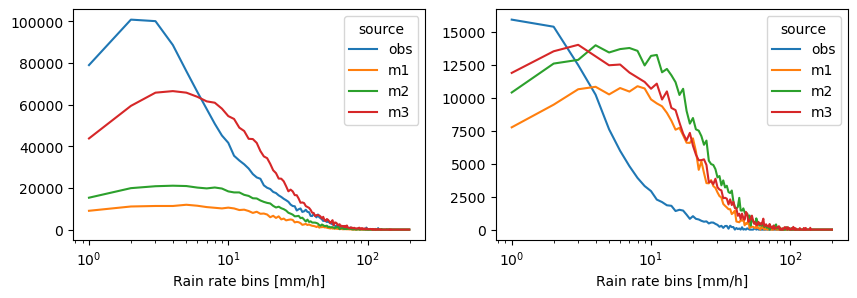

In [12]:
fig, axes = plt.subplots(1, 2, figsize=[10,3], dpi=100)
ax0 = axes[0]
xr.plot.line(mcsamt_hist_o, x='bins', ax=ax0)
# ax0.set_yscale('log')
ax0.set_xscale('log')
ax1 = axes[1]
xr.plot.line(idcamt_hist_o, x='bins', ax=ax1)
# ax1.set_yscale('log')
ax1.set_xscale('log')

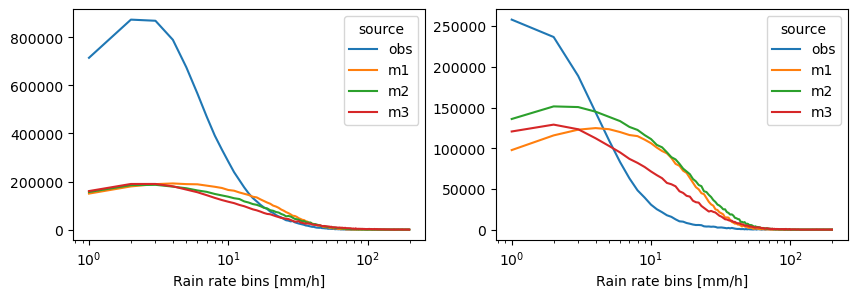

In [13]:
fig, axes = plt.subplots(1, 2, figsize=[10,3], dpi=100)
ax0 = axes[0]
xr.plot.line(mcsamt_hist_l, x='bins', ax=ax0)
# ax0.set_yscale('log')
ax0.set_xscale('log')
ax1 = axes[1]
xr.plot.line(idcamt_hist_l, x='bins', ax=ax1)
# ax1.set_yscale('log')
ax1.set_xscale('log')

## Calculate cumulative histogram of rain amount by rain rate

In [14]:
# Ocean
mcsamt_cumhist_o = (ds.mcs_ocean * rrbins).cumsum(dim='bins')
idcamt_cumhist_o = (ds.idc_ocean * rrbins).cumsum(dim='bins') 
# # Normalized by total rain amount for each type
# norm_mcsamt_cumhist_o = mcsamt_cumhist_o / (ds.mcs_ocean * rrbins).sum(dim='bins')
# norm_idcamt_cumhist_o = idcamt_cumhist_o / (ds.idc_ocean * rrbins).sum(dim='bins')

# Land
mcsamt_cumhist_l = (ds.mcs_land * rrbins).cumsum(dim='bins')
idcamt_cumhist_l = (ds.idc_land * rrbins).cumsum(dim='bins') 
# # Normalized by total rain amount for each type
# norm_mcsamt_cumhist_l = mcsamt_cumhist_l / (ds.mcs_land * rrbins).sum(dim='bins')
# norm_idcamt_cumhist_l = idcamt_cumhist_l / (ds.idc_land * rrbins).sum(dim='bins')

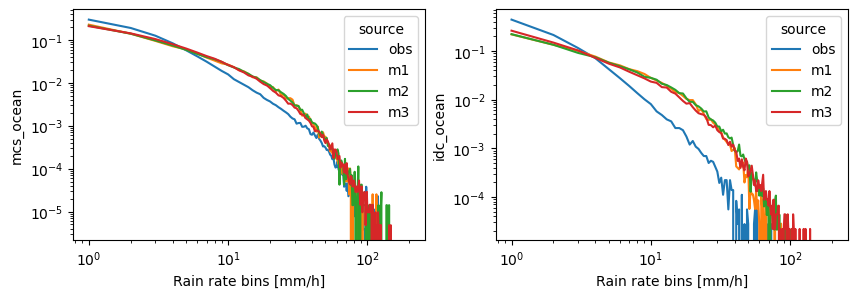

In [15]:
fig, axes = plt.subplots(1, 2, figsize=[10,3], dpi=100)
ax0 = axes[0]
xr.plot.line(norm_mcs_o, x='bins', ax=ax0)
ax0.set_yscale('log')
ax0.set_xscale('log')
ax1 = axes[1]
xr.plot.line(norm_idc_o, x='bins', ax=ax1)
ax1.set_yscale('log')
ax1.set_xscale('log')

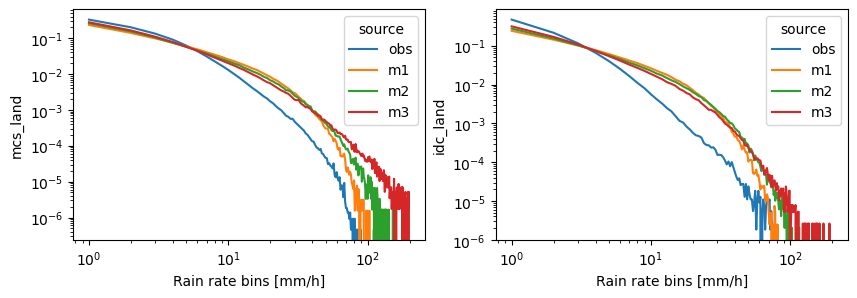

In [16]:
fig, axes = plt.subplots(1, 2, figsize=[10,3], dpi=100)
ax0 = axes[0]
xr.plot.line(norm_mcs_l, x='bins', ax=ax0)
ax0.set_yscale('log')
ax0.set_xscale('log')
ax1 = axes[1]
xr.plot.line(norm_idc_l, x='bins', ax=ax1)
ax1.set_yscale('log')
ax1.set_xscale('log')

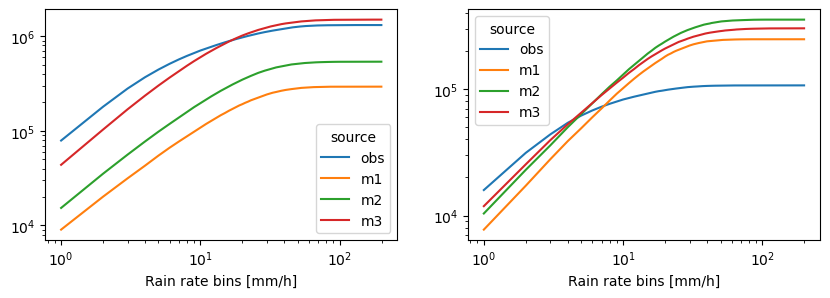

In [17]:
fig, axes = plt.subplots(1, 2, figsize=[10,3], dpi=100)
ax0 = axes[0]
xr.plot.line(mcsamt_cumhist_o, x='bins', ax=ax0)
ax0.set_yscale('log')
ax0.set_xscale('log')
ax1 = axes[1]
xr.plot.line(idcamt_cumhist_o, x='bins', ax=ax1)
ax1.set_yscale('log')
ax1.set_xscale('log')

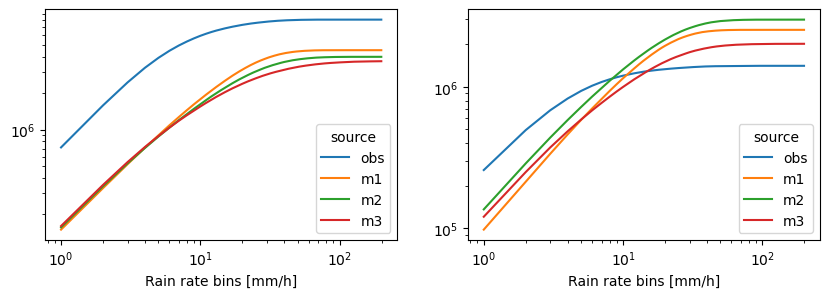

In [18]:
fig, axes = plt.subplots(1, 2, figsize=[10,3], dpi=100)
ax0 = axes[0]
xr.plot.line(mcsamt_cumhist_l, x='bins', ax=ax0)
ax0.set_yscale('log')
ax0.set_xscale('log')
ax1 = axes[1]
xr.plot.line(idcamt_cumhist_l, x='bins', ax=ax1)
ax1.set_yscale('log')
ax1.set_xscale('log')

In [19]:
legends = {
    'obs': model_name[name_map['obs']],
    'm1': model_name[name_map['m1']],
    'm2': model_name[name_map['m2']],
    'm3': model_name[name_map['m3']],
}
# Global
# map_extent = [lon_bounds[0],lon_bounds[1]-1,lat_bounds[0]-20,lat_bounds[1]+20]
# lonbox = [lon_bounds[0], lon_bounds[1]-1]
# latbox = [lat_bounds[0], lat_bounds[1]]
# Regional
map_extent = [lon_bounds[0]-10,lon_bounds[1]+10,lat_bounds[0]-10,lat_bounds[1]+10]
lonbox = [lon_bounds[0], lon_bounds[1]]
latbox = [lat_bounds[0], lat_bounds[1]]
map_extent, lonbox, latbox

([-89.0, -26.0, -28.0, 21.0], [-79.0, -36.0], [-18.0, 11.0])

## Function to plot mirror PDF

In [20]:
def plot_pdf_mirror_mxn(nrow, ncol, nrowsub, ncolsub, bins, data_top, data_bot, titles, xlabels, ylabels, legends, figname,  
                map_extent=None, lonbox=None, latbox=None, inset_param=None, map_panel=None,
                xscale=None, yscale=None, xlims=None, ylims=None, label_topbot=None, label_pos=None,
                legend_fontsize=11, legend_loc=None, legend_ncol=None, figsize=None):
    
    mpl.rcParams['font.size'] = 13
    mpl.rcParams['font.family'] = 'Helvetica'
    mpl.rcParams['font.weight'] = 'regular'
    
    lw = 2
    lcolors = {
        'obs': 'k', 
        'm1': 'dodgerblue',
        'm2': 'green', 
        'm3': 'darkorange',
    }
    # lcolors = {
    #     'obs':'k', 
    #     'm1': 'crimson',
    #     'm2': 'darkorange', 
    #     'm3': 'gold',
    #     'm4': 'green',
    #     'm5': 'blue',
    #     'm6': 'purple',
    # }
    
    fig = plt.figure(figsize=figsize, constrained_layout=False, dpi=100)
    outer_grid = fig.add_gridspec(nrow, ncol, wspace=0.25, hspace=0)

    for row in range(nrow):
        for col in range(ncol):
            # gridspec inside gridspec
            inner_grid = outer_grid[row, col].subgridspec(nrowsub, ncolsub, wspace=0, hspace=0)
            axs = inner_grid.subplots()
            ax1 = axs[0]  # top
            ax2 = axs[1]  # bottom
            # Top panel
            ax1.plot(bins, data_top[row][col].sel(source='obs'), lcolors['obs'], lw=lw*2.5, label=legends['obs'])
            ax1.plot(bins, data_top[row][col].sel(source='m1'), lcolors['m1'], lw=lw, label=legends['m1'])
            ax1.plot(bins, data_top[row][col].sel(source='m2'), lcolors['m2'], lw=lw, label=legends['m2'])
            ax1.plot(bins, data_top[row][col].sel(source='m3'), lcolors['m3'], lw=lw, label=legends['m3'])
            # # Bottom panel
            ax2.plot(bins, data_bot[row][col].sel(source='obs'), lcolors['obs'], lw=lw*2.5, label=legends['obs'])
            ax2.plot(bins, data_bot[row][col].sel(source='m1'), lcolors['m1'], lw=lw, label=legends['m1'])
            ax2.plot(bins, data_bot[row][col].sel(source='m2'), lcolors['m2'], lw=lw, label=legends['m2'])
            ax2.plot(bins, data_bot[row][col].sel(source='m3'), lcolors['m3'], lw=lw, label=legends['m3'])
            # Labels, gridlines, etc.
            ax1.grid(which='major', ls='--')
            ax2.grid(which='major', ls='--')
            ax1.set_title(titles[row][col], loc='left')
            ax2.set_xlabel(xlabels)
            # Label top/bottom panels
            ax1.text(label_pos['top']['x'], label_pos['top']['y'], label_topbot['top'], ha='left', transform=ax1.transAxes)
            ax2.text(label_pos['top']['x'], label_pos['top']['y'], label_topbot['bottom'], ha='left', transform=ax2.transAxes)
            # Label yaxis, legend
            if (col == 0):
                ax1.legend(fontsize=legend_fontsize, loc=legend_loc[0], ncol=legend_ncol[0])
            ax1.text(-0.15, 1, ylabels[row][col], va='center', ha='center', rotation=90, transform=ax2.transAxes)
            ax1.set_yscale(yscale[row][col])
            ax2.set_yscale(yscale[row][col])
            ax1.set_xscale(xscale)
            ax2.set_xscale(xscale)
            ax1.tick_params(labelbottom=False)
            
            ax1.set_xlim(xlims[0], xlims[1])
            ax2.set_xlim(xlims[0], xlims[1])
            ax1.set_ylim(ylims[row][col][0], ylims[row][col][1])
            ax2.set_ylim(ylims[row][col][0], ylims[row][col][1])
            
            # Plot inset map
            if (row == map_panel['row']) & (col == map_panel['col']) & (map_panel['rowsub'] == 0) & (map_panel['colsub'] == 0):
                resolution = '110m'
                land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
                ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
                # proj = ccrs.PlateCarree(central_longitude=180)
                proj = ccrs.PlateCarree(central_longitude=0)
                box_proj = ccrs.PlateCarree(central_longitude=0)
                sub_ax = inset_axes(ax1, width=inset_param['width'], height=inset_param['height'], loc=inset_param['loc'],
                                    axes_class=cartopy.mpl.geoaxes.GeoAxes, borderpad=inset_param['borderpad'], 
                                    axes_kwargs=dict(projection=proj))
                sub_ax.set_extent(map_extent, box_proj)
                # Add land, coastlines, borders to inset
                sub_ax.add_feature(land, facecolor='gainsboro', edgecolor='k')
                sub_ax.add_feature(ocean, edgecolor='none', facecolor=cfeature.COLORS['water'])
                # sub_ax.add_feature(borders, edgecolor=lcolors['obs'], facecolor='none', zorder=4)
                sub_ax.add_feature(land, facecolor='none', edgecolor='k', zorder=4)
                # Define the vertices of the rectangle in the projection coordinates
                x1, y1 = proj.transform_point(lon_bounds[0], lat_bounds[0], proj)
                x2, y2 = proj.transform_point(lon_bounds[1], lat_bounds[1], proj)
                # Plot rectangle
                sub_ax.add_patch(mpl.patches.Rectangle((x1, y1), x2-x1, y2-y1, transform=proj, fill=None, lw=2, edgecolor='g', zorder=10))
                sub_ax.add_patch(mpl.patches.Rectangle((x1, y1), x2-x1, y2-y1, transform=proj, fill='g', edgecolor=None, alpha=0.6, zorder=10))

    fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

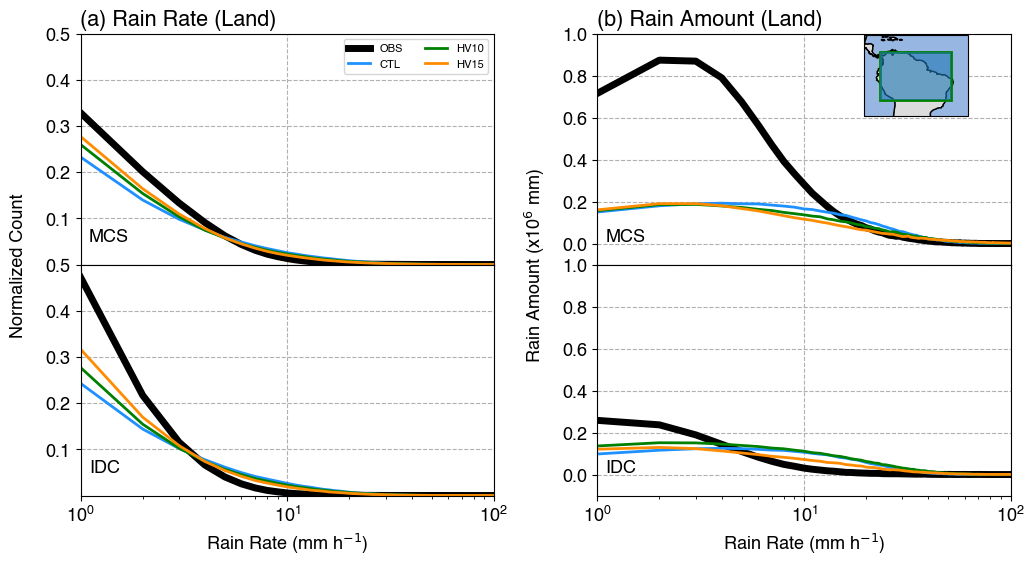

In [30]:
bins = rrbins
amt_scale_factor = 6
amt_scale = 10**amt_scale_factor
data_top = [
    [norm_mcs_l, mcsamt_hist_l/amt_scale,], 
]
data_bot = [
    [norm_idc_l, idcamt_hist_l/amt_scale,], 
]
titles = [
    ['(a) Rain Rate (Land)', '(b) Rain Amount (Land)'],
]
xlabels = 'Rain Rate (mm h$^{-1}$)'
ylabels = [
    ['Normalized Count', f'Rain Amount (x10$^{amt_scale_factor}$ mm)'],
]
label_topbot = {'top':'MCS', 'bottom':'IDC'}
label_pos = {'top':{'x':0.02, 'y':0.1}, 'bottom':{'x':0.02, 'y':0.9}}
legend_loc = ['upper right', 'upper right']
legend_ncol = [2, 2]
map_panel = {'row': 0, 'col': 1, 'rowsub': 0, 'colsub': 0}
xscale = 'log'
yscale = [['linear','linear'],['linear','linear']]
xlims = [1, 100]
ylims = [[[1e-5,0.5], [-0.1,1.0]]]
# ylims = [[[1e-5,1], [-0.1,1.0]]]
inset_param = {'width':'45%', 'height':'35%', 'loc':'upper right', 'borderpad':0.1}
figname = f'{figdir}rainrate_rainamount_pdf_mcs_idc_{region}.png'
# figname = f'{figdir}rainrate_rainamount_pdf_mcs_idc_{region}.pdf'
fig = plot_pdf_mirror_mxn(1, 2, 2, 1, bins, data_top, data_bot, titles, xlabels, ylabels, legends, figname,
                   map_extent=map_extent, lonbox=lonbox, latbox=latbox, inset_param=inset_param, map_panel=map_panel,
                   xscale=xscale, yscale=yscale, xlims=xlims, ylims=ylims, label_topbot=label_topbot, label_pos=label_pos,
                   legend_fontsize=8, legend_loc=legend_loc, legend_ncol=legend_ncol, figsize=[12,6])

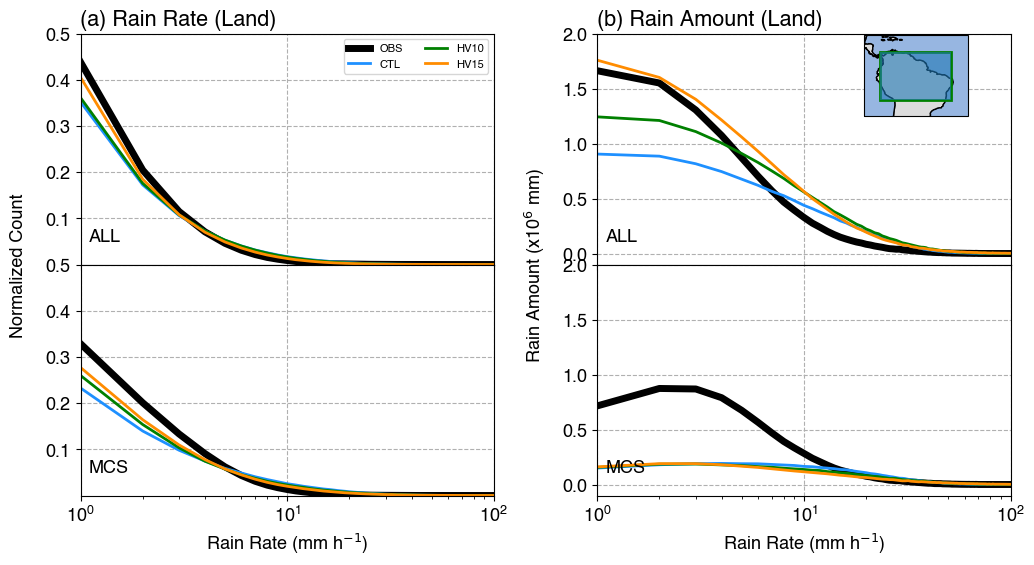

In [32]:
bins = rrbins
amt_scale_factor = 6
amt_scale = 10**amt_scale_factor
data_top = [
    [norm_tot_l, totamt_hist_l/amt_scale,], 
]
data_bot = [
    [norm_mcs_l, mcsamt_hist_l/amt_scale,], 
]
titles = [
    ['(a) Rain Rate (Land)', '(b) Rain Amount (Land)'],
]
xlabels = 'Rain Rate (mm h$^{-1}$)'
ylabels = [
    ['Normalized Count', f'Rain Amount (x10$^{amt_scale_factor}$ mm)'],
]
label_topbot = {'top':'ALL', 'bottom':'MCS'}
label_pos = {'top':{'x':0.02, 'y':0.1}, 'bottom':{'x':0.02, 'y':0.9}}
legend_loc = ['upper right', 'upper right']
legend_ncol = [2, 2]
map_panel = {'row': 0, 'col': 1, 'rowsub': 0, 'colsub': 0}
xscale = 'log'
yscale = [['linear','linear'],['linear','linear']]
xlims = [1, 100]
# ylims = [[[1e-5,1], [-0.1,2.0]]]
ylims = [[[1e-5,0.5], [-0.1,2.0]]]
inset_param = {'width':'45%', 'height':'35%', 'loc':'upper right', 'borderpad':0.1}
figname = f'{figdir}rainrate_rainamount_pdf_total_mcs_{region}.png'
fig = plot_pdf_mirror_mxn(1, 2, 2, 1, bins, data_top, data_bot, titles, xlabels, ylabels, legends, figname,
                   map_extent=map_extent, lonbox=lonbox, latbox=latbox, inset_param=inset_param, map_panel=map_panel,
                   xscale=xscale, yscale=yscale, xlims=xlims, ylims=ylims, label_topbot=label_topbot, label_pos=label_pos,
                   legend_fontsize=8, legend_loc=legend_loc, legend_ncol=legend_ncol, figsize=[12,6])

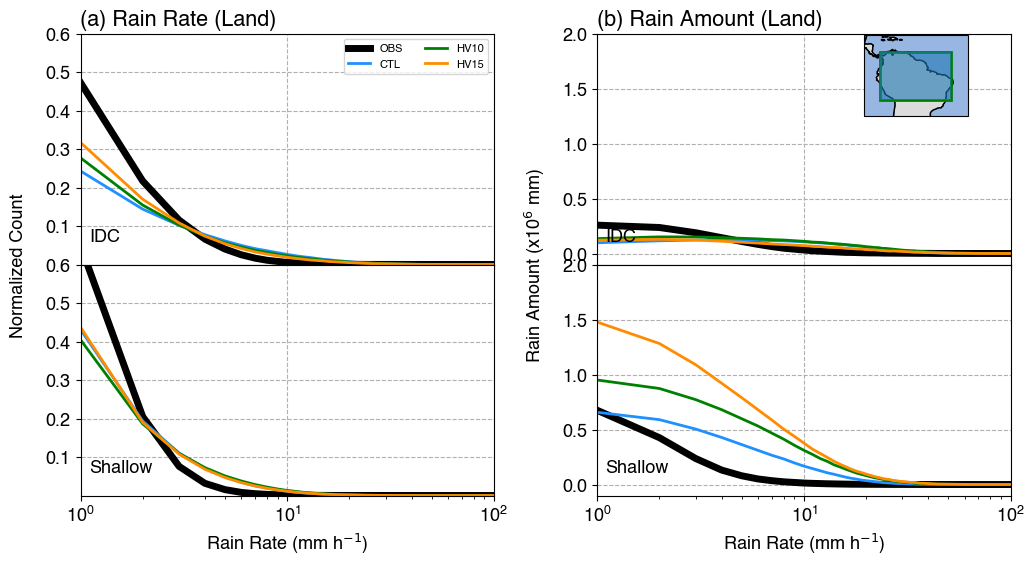

In [34]:
bins = rrbins
amt_scale_factor = 6
amt_scale = 10**amt_scale_factor
data_top = [
    [norm_idc_l, idcamt_hist_l/amt_scale,], 
]
data_bot = [
    [norm_cong_l, congamt_hist_l/amt_scale,], 
]
titles = [
    ['(a) Rain Rate (Land)', '(b) Rain Amount (Land)'],
]
xlabels = 'Rain Rate (mm h$^{-1}$)'
ylabels = [
    ['Normalized Count', f'Rain Amount (x10$^{amt_scale_factor}$ mm)'],
]
label_topbot = {'top':'IDC', 'bottom':'Shallow'}
label_pos = {'top':{'x':0.02, 'y':0.1}, 'bottom':{'x':0.02, 'y':0.9}}
legend_loc = ['upper right', 'upper right']
legend_ncol = [2, 2]
map_panel = {'row': 0, 'col': 1, 'rowsub': 0, 'colsub': 0}
xscale = 'log'
yscale = [['linear','linear'],['linear','linear']]
xlims = [1, 100]
# ylims = [[[1e-5,1], [-0.1,1.5]]]
ylims = [[[1e-5,0.6], [-0.1,2.0]]]
inset_param = {'width':'45%', 'height':'35%', 'loc':'upper right', 'borderpad':0.1}
figname = f'{figdir}rainrate_rainamount_pdf_idc_congestus_{region}.png'
fig = plot_pdf_mirror_mxn(1, 2, 2, 1, bins, data_top, data_bot, titles, xlabels, ylabels, legends, figname,
                   map_extent=map_extent, lonbox=lonbox, latbox=latbox, inset_param=inset_param, map_panel=map_panel,
                   xscale=xscale, yscale=yscale, xlims=xlims, ylims=ylims, label_topbot=label_topbot, label_pos=label_pos,
                   legend_fontsize=8, legend_loc=legend_loc, legend_ncol=legend_ncol, figsize=[12,6])

In [24]:
figname

'/global/cfs/cdirs/m1657/zfeng/amazon_hvmixing/figures/rainrate_rainamount_pdf_idc_congestus_fulldomain.png'

In [25]:
def plot_pdf_mxn(nrow, ncol, bins, data_arr, titles, xlabels, ylabels, legends, figname,  
                map_extent=None, lonbox=None, latbox=None, inset_param=None, map_panel=[0,0],
                xscale=None, yscale=None, xlims=None, ylims=None,
                legend_fontsize=11, legend_loc='best', figsize=[10,10]):
    
    mpl.rcParams['font.size'] = 12
    mpl.rcParams['font.family'] = 'Helvetica'
    mpl.rcParams['font.weight'] = 'regular'
    fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=figsize, dpi=100)

    lw = 2
    lcolors = {
        'obs': 'k', 
        'm1': 'dodgerblue',
        'm2': 'green', 
        'm3': 'darkorange',
    }

    for row in range(0, nrow):
        for col in range(0, ncol): 
            ax = axes[row][col]           
            ax.plot(bins, data_arr[row][col].sel(source='obs'), lcolors['obs'], lw=lw*2.5, label=legends['obs'])
            ax.plot(bins, data_arr[row][col].sel(source='m1'), lcolors['m1'], lw=lw, label=legends['m1'])
            ax.plot(bins, data_arr[row][col].sel(source='m2'), lcolors['m2'], lw=lw, label=legends['m2'])
            ax.plot(bins, data_arr[row][col].sel(source='m3'), lcolors['m3'], lw=lw, label=legends['m3'])
            # Labels
            # if (row == 0): 
            ax.legend(fontsize=legend_fontsize, loc=legend_loc)
            ax.grid(which='major', ls='--')
            ax.set_title(titles[row][col], loc='right')
            ax.set_xlabel(xlabels)
            ax.set_ylabel(ylabels[row][col])
            ax.set_yscale(yscale[row])
            ax.set_xscale(xscale)
            # ax.set_xticks(xticks[col])
            ax.set_xlim(xlims[0], xlims[1])
            ax.set_ylim(ylims[row][col][0], ylims[row][col][1])
            
            # Plot inset map
            if (row == map_panel[0]) & (col == map_panel[1]):
                resolution = '110m'
                land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
                ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
                # borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)
                proj = ccrs.PlateCarree(central_longitude=180)
                box_proj = ccrs.PlateCarree(central_longitude=0)
                sub_ax = inset_axes(ax, width=inset_param['width'], height=inset_param['height'], loc=inset_param['loc'],
                                    axes_class=cartopy.mpl.geoaxes.GeoAxes, borderpad=inset_param['borderpad'], 
                                    axes_kwargs=dict(map_projection=proj))
                sub_ax.set_extent(map_extent, box_proj)
                # Add land, coastlines, borders to inset
                sub_ax.add_feature(land, facecolor='gainsboro', edgecolor='k')
                sub_ax.add_feature(ocean, edgecolor='none', facecolor=cfeature.COLORS['water'])
                # sub_ax.add_feature(borders, edgecolor=lcolors['obs'], facecolor='none', zorder=4)
                sub_ax.add_feature(land, facecolor='none', edgecolor='k', zorder=4)
                # Plot a box region in the inset
                box = sgeom.box(minx=lonbox[0], maxx=lonbox[1], miny=latbox[0], maxy=latbox[1])
                sub_ax.add_geometries([box], box_proj, facecolor='none', edgecolor='g', lw=2)
                sub_ax.add_geometries([box], box_proj, facecolor='g', edgecolor='none', alpha=0.3)

    fig.tight_layout(w_pad=0.8, h_pad=0.5)
    fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

/global/common/software/m1867/python/pyflex/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/tmp/ipykernel_1339748/3858728400.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(w_pad=0.8, h_pad=0.5)


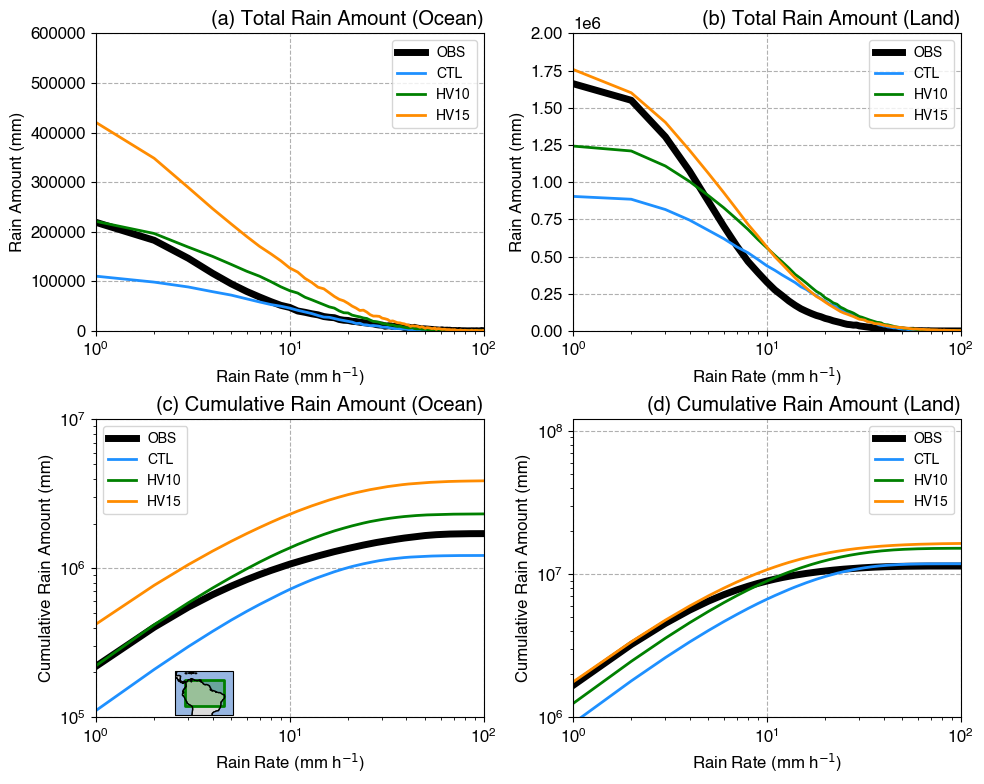

In [26]:
# amt_scale_factor = 6
# amt_scale = 10**amt_scale_factor

bins = rrbins
data_arr = [
    [totamt_hist_o, totamt_hist_l,], 
    [totamt_cumhist_o, totamt_cumhist_l,],
]
titles = [
    ['(a) Total Rain Amount (Ocean)', '(b) Total Rain Amount (Land)', ],
    ['(c) Cumulative Rain Amount (Ocean)', '(d) Cumulative Rain Amount (Land)'],
]
xlabels = 'Rain Rate (mm h$^{-1}$)'
ylabels = [
    ['Rain Amount (mm)', 'Rain Amount (mm)'],
    ['Cumulative Rain Amount (mm)', 'Cumulative Rain Amount (mm)'],
]
xscale = 'log'
yscale = ['linear','log']
xlims = [1, 100]
ylims = [
    [[0,0.6e6], [0,2e6]],
    [[1e5,1e7], [1e6,1.2e8]],
]
inset_param = {'width':'55%', 'height':'15%', 'loc':'lower left', 'borderpad':0.1}
figname = f'{figdir}rainrate_rainamount_pdf_total_{region}.png'
fig = plot_pdf_mxn(2, 2, bins, data_arr, titles, xlabels, ylabels, legends, figname,
                   map_extent=map_extent, lonbox=lonbox, latbox=latbox, inset_param=inset_param, map_panel=[1,0],
                   xscale=xscale, yscale=yscale, xlims=xlims, ylims=ylims,
                   legend_fontsize=10, legend_loc='best', figsize=[10,8])

In [27]:
figdir

'/global/cfs/cdirs/m1657/zfeng/amazon_hvmixing/figures/'